In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from ModifiedVGG16 import ModifiedVGG16
import json
import time

2025-03-08 17:48:11.792317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [2]:
from keras.optimizers import Adam
import keras
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
"""
training_data, validation_data = keras.preprocessing.image_dataset_from_directory(
    './dataset',  # the path to the dataset
    labels='inferred',  # keep the original folder structure (class names)
    label_mode='int',   # use integer labels
    class_names=None,   # class names will be inferred from the folder structure
    color_mode='grayscale',   # the images are MRI scans in grayscale
    batch_size=32,  # images will be fed in batches of 32
    image_size=(224, 224),  # images will be resized to 224x224 pixels - the input size of the VGG16 model
    validation_split=0.2,   # 20% of the images will be used for validation, 80% for training
    subset='both',  # the data generator will return training data
    shuffle=True,   # shuffle the images randomly before training - this is important to avoid overfitting
    seed=42         # provide a seed to ensure no overlap between training and validation subsets
)

print(training_data.class_names)
print(training_data)

"""

"\ntraining_data, validation_data = keras.preprocessing.image_dataset_from_directory(\n    './dataset',  # the path to the dataset\n    labels='inferred',  # keep the original folder structure (class names)\n    label_mode='int',   # use integer labels\n    class_names=None,   # class names will be inferred from the folder structure\n    color_mode='grayscale',   # the images are MRI scans in grayscale\n    batch_size=32,  # images will be fed in batches of 32\n    image_size=(224, 224),  # images will be resized to 224x224 pixels - the input size of the VGG16 model\n    validation_split=0.2,   # 20% of the images will be used for validation, 80% for training\n    subset='both',  # the data generator will return training data\n    shuffle=True,   # shuffle the images randomly before training - this is important to avoid overfitting\n    seed=42         # provide a seed to ensure no overlap between training and validation subsets\n)\n\nprint(training_data.class_names)\nprint(training_da

We should proceed another way to preprocess the data (and especially load it). Since we are not yet quite familiar with TensorFlow or Keras, we will import the data ourselves and preprocess it.

First, let's store the labels in a variable.

In [3]:
dataset_path = "./dataset"

class_names = os.listdir(dataset_path)
class_names = sorted(class_names)
class_names.remove('.DS_Store')
nb_classes = len(class_names)
print(f'The dataset contains {nb_classes} classes: {class_names}')

The dataset contains 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


Now, we want to load the images. To do so, we will use the `cv2` library. We will load the images and resize them to 224x224 pixels. We will also normalize the images by dividing them by 255.

Finally, we will split the data into training and validation sets.

In [4]:
image_size = (224, 224)
batch_size = 32

X = []
y = []

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        img = cv2.resize(img, image_size)  # Resize to 224x224 (image size of VGG16)
        img = img / 255.0  # Normalize pixel value to [0, 1]
        X.append(img)
        y.append(class_name)


In [5]:
# Convert to numpy arrays
X = np.array(X, dtype=np.float32).reshape(-1, 224, 224, 1)  # Reshape for CNN
y_label = np.array(y).reshape(-1, 1)


In [6]:
print(y_label.shape)

(5712, 1)


In [7]:
# Encode class labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y_label)  # Convert class names to binary

In [8]:
print(X.shape)
print(y_label.shape)
print(y.shape)
print(y)

(5712, 224, 224, 1)
(5712, 1)
(5712, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


Shape of an image is (224, 224, 1)


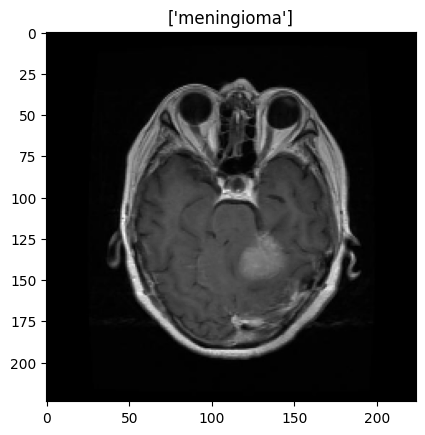

In [9]:
# Display a random image
rd = np.random.randint(0, len(X))
image = X[rd]
label = y_label[rd]
print(f'Shape of an image is {image.shape}')
plt.imshow(image, cmap='gray')
plt.title(label)
plt.show()

The data has now been preprocessed, which means :
- the images have all been resied to the shape (224 x 224)
- the pixel values have been normalised (/255)
- the images have been loaded in greyscale

But we now need to determine which metric is of importance to assess the performance of our model. This means doing some EDA, notably checking the class distribution. If it is balanced, assessing the performance of the model with accuracy should do.

Glioma: 1321
Meningioma: 1339
No Tumor: 1595
Glioma: 1457


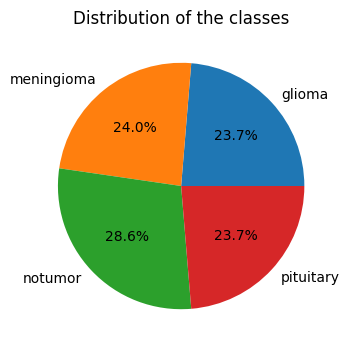

In [10]:
glioma_count = (y_label == 'glioma').sum()
meningioma_count = (y_label == 'meningioma').sum()
notumor_count = (y_label == 'notumor').sum()
pituitary_count = (y_label == 'pituitary').sum()

print(f"Glioma: {glioma_count}")
print(f"Meningioma: {meningioma_count}")
print(f"No Tumor: {notumor_count}")
print(f"Glioma: {pituitary_count}")

distribution = [glioma_count, meningioma_count, notumor_count, glioma_count]

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)

fig = plt.figure(figsize=(6, 4))
plt.pie(distribution, labels=class_names, autopct=lambda pct: func(pct, distribution))
plt.title("Distribution of the classes")
plt.savefig('./images/distribution.png')
plt.show()


The class distribution is quite well balanced. This means we can theoretically assess the model performance with the accuracy metric. We will then plot the confusion matrix to ensure that the prediction errors are well balanced. If not, we will reassess this hypothesis.

We can now split the data into two datasets : the training set and the testing set.

In [11]:
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (5712, 224, 224, 1), y shape: (5712, 4)


In [12]:
# First split: Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [13]:
# Second split: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Here, the data is shuffled and stritified. That means we ensure robustness, while keeping our class distribution as balanced as the original data.

Now we are ready to train, then test, our neural network. For this model, we will first implement a VGG-16 CNN.

In [14]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4569, 224, 224, 1)
X_val shape: (571, 224, 224, 1)
X_test shape: (572, 224, 224, 1)
y_train shape: (4569, 4)
y_val shape: (571, 4)
y_test shape: (572, 4)


In [15]:
# Quick tests to ensure the data is consistent and correctly split

assert len(X) == len(y), "X and y should be of same length" # If not, some images will be missing a label
assert len(X_train) == len(y_train), "X_train and y_train must be of same length"
assert len(X_val) == len(y_val), "X_val and y_val must be of same length"
assert len(X_test) == len(y_test), "X_test and y_test must be of same length"
assert len(X_train) + len(X_test) + len(X_val) == len(X), "X must be on length len(X_train) + len(X_test)"

The training data is ready to be fed to the CNN to train the model.

In [ ]:
optimizer = Adam(learning_rate=0.001)
ModifiedVGG16.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy', 'precision', 'recall', 'f1_score', 'categorical_crossentropy', 'AUC'])

In [ ]:
ModifiedVGG16.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,275,780 (512.22 MB)

 Trainable params: 134,275,780 (512.22 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop if no improvement for 5 consecutive epochs
    restore_best_weights=True  # Restore the best weights before stopping
)

In [ ]:
start_time = time.time()

history = ModifiedVGG16.fit(
    X_train, y_train,  # Training data
    validation_data=(X_val, y_val),  # Validation data
    epochs=20,  # Number of training iterations
    batch_size=batch_size,  # Number of samples per training batch
    verbose=1,  # Shows training progress
    callbacks=[early_stopping]  # Early stopping
)

training_time = time.time() - start_time
print(f"Training time of {training_time} seconds")

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 3740s 26s/step - AUC: 0.5155 - accuracy: 0.2833 - categorical_crossentropy: 1.4041 - f1_score: 0.1683 - loss: 1.4041 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5207 - val_accuracy: 0.2750 - val_categorical_crossentropy: 1.3851 - val_f1_score: 0.1078 - val_loss: 1.3851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 3835s 27s/step - AUC: 0.5323 - accuracy: 0.2842 - categorical_crossentropy: 1.3827 - f1_score: 0.1106 - loss: 1.3827 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5231 - val_accuracy: 0.2750 - val_categorical_crossentropy: 1.3845 - val_f1_score: 0.1078 - val_loss: 1.3845 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
  5/143 ━━━━━━━━━━━━━━━━━━━━ 1:08:23 30s/step - AUC: 0.5576 - accuracy: 0.2460 - categorical_crossentropy: 1.3834 - f1_score: 0.0982 - loss: 1.3834 - precision: 0.0000e+00 - recall: 0.0000e+00

: 

After training the model for more than 2h30, the model crashed, with the following error : 

Le noyau s’est bloqué lors de l’exécution du code dans une cellule active ou une cellule précédente. 
Veuillez vérifier le code dans la ou les cellules pour identifier une cause possible de l’échec. 
Cliquez <a href='https://aka.ms/vscodeJupyterKernelCrash'>ici</a> pour plus d’informations. 
Pour plus d’informations, consultez Jupyter <a href='command:jupyter.viewOutput'>log</a>.

Workspace folder ~/Documents/GitHub/Brain-Tumor-MRI-Classification-
14:46:11.117 [info] Deleting old temp dir /Users/~/Library/Application Support/Code/User/globalStorage/ms-toolsai.jupyter/version-2025.1.0
14:46:12.410 [info] Starting Kernel (Python Path: /usr/local/bin/python3, Unknown, 3.10.4) for '~/Documents/GitHub/Brain-Tumor-MRI-Classification-/main.ipynb' (disableUI=true)
14:46:14.737 [warn] Failed to get activated env vars for /usr/local/bin/python3 in 2328ms
14:46:14.740 [warn] Failed to get activated env vars for /usr/local/bin/python3 in 1752ms
14:46:14.744 [info] Process Execution: /usr/local/bin/python3 -c "import site;print("USER_BASE_VALUE");print(site.USER_BASE);print("USER_BASE_VALUE");"
14:46:14.916 [info] Process Execution: /usr/local/bin/python3 -m pip list
14:46:14.917 [info] Process Execution: /usr/local/bin/python3 -c "import ipykernel; print(ipykernel.__version__); print("5dc3a68c-e34e-4080-9c3e-2a532b2ccb4d"); print(ipykernel.__file__)"
14:46:14.919 [info] Process Execution: /usr/local/bin/python3 -m ipykernel_launcher --f=/Users/~/Library/Jupyter/runtime/kernel-v3c24c181ad434a699b0838527cc2940475f4d5043.json
    > cwd: ~/Documents/GitHub/Brain-Tumor-MRI-Classification-
14:46:17.591 [info] Kernel successfully started
14:46:31.026 [info] Process Execution: /usr/local/bin/python3 /Users/~/.vscode/extensions/ms-toolsai.jupyter-2025.2.0-darwin-x64/pythonFiles/printJupyterDataDir.py
14:51:17.428 [info] Interrupt kernel execution
14:51:17.430 [info] Interrupt requested ~/Documents/GitHub/Brain-Tumor-MRI-Classification-/main.ipynb
14:51:17.432 [info] Interrupt kernel execution
14:51:17.432 [info] Interrupting kernel: python3104jvsc74a57bd0aee8b7b246df8f9039afb4144a1f6fd8d2ca17a180786b69acc140d282b71a49
14:51:17.432 [info] Interrupting kernel via SIGINT
14:51:27.485 [info] Interrupt requested & sent for ~/Documents/GitHub/Brain-Tumor-MRI-Classification-/main.ipynb in notebookEditor.
14:51:29.452 [info] Restart requested ~/Documents/GitHub/Brain-Tumor-MRI-Classification-/main.ipynb
14:51:29.515 [warn] Failed to get activated env vars for /usr/local/bin/python3 in 30ms
14:51:29.517 [info] Process Execution: /usr/local/bin/python3 -c "import ipykernel; print(ipykernel.__version__); print("5dc3a68c-e34e-4080-9c3e-2a532b2ccb4d"); print(ipykernel.__file__)"
14:51:29.522 [info] Process Execution: /usr/local/bin/python3 -m ipykernel_launcher --f=/Users/~/Library/Jupyter/runtime/kernel-v37c5f90f6f6aa7e7b2818f475952eba22fd37135f.json
    > cwd: ~/Documents/GitHub/Brain-Tumor-MRI-Classification-
14:51:30.975 [info] Restarted f934ca58-3e78-4e35-aa9d-85f37c776f2a
14:52:34.037 [warn] Cell completed with errors su [Error]: invalid syntax. Perhaps you forgot a comma? (2801906234.py, line 8)
    at n.execute (/Users/~/.vscode/extensions/ms-toolsai.jupyter-2025.2.0-darwin-x64/dist/extension.node.js:294:4958) {
  ename: 'SyntaxError',
  evalue: 'invalid syntax. Perhaps you forgot a comma? (2801906234.py, line 8)',
  traceback: [
    '\x1B[0;36m  Cell \x1B[0;32mIn[19], line 8\x1B[0;36m\x1B[0m\n' +
      '\x1B[0;31m    verbose=1  # Shows training progress\x1B[0m\n' +
      '\x1B[0m            ^\x1B[0m\n' +
      '\x1B[0;31mSyntaxError\x1B[0m\x1B[0;31m:\x1B[0m invalid syntax. Perhaps you forgot a comma?\n'
  ]
}
14:52:34.044 [warn] Cancel all remaining cells due to cancellation or failure in execution
17:02:04.373 [error] Disposing session as kernel process died ExitCode: undefined, Reason: 2025-03-08 14:51:49.433273: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

17:24:44.289 [error] Failed to write data to the kernel channel shell [
  <Buffer 3c 49 44 53 7c 4d 53 47 3e>,
  <Buffer 34 62 36 32 33 61 30 61 30 34 61 39 36 33 34 38 64 31 61 64 34 65 36 38 65 35 35 35 38 38 62 34 38 64 38 39 38 65 62 38 39 34 36 37 35 63 36 64 34 39 ... 14 more bytes>,
  <Buffer 7b 22 64 61 74 65 22 3a 22 32 30 32 35 2d 30 33 2d 30 38 54 31 36 3a 32 34 3a 34 34 2e 32 38 36 5a 22 2c 22 6d 73 67 5f 69 64 22 3a 22 36 65 38 37 33 ... 177 more bytes>,
  <Buffer 7b 7d>,
  <Buffer 7b 7d>,
  <Buffer 7b 22 73 69 6c 65 6e 74 22 3a 66 61 6c 73 65 2c 22 73 74 6f 72 65 5f 68 69 73 74 6f 72 79 22 3a 66 61 6c 73 65 2c 22 75 73 65 72 5f 65 78 70 72 65 73 ... 12617 more bytes>
] Error: Socket is closed
    at a.postToSocket (/Users/~/.vscode/extensions/ms-toolsai.jupyter-2025.2.0-darwin-x64/dist/extension.node.js:301:8060)
    at /Users/~/.vscode/extensions/ms-toolsai.jupyter-2025.2.0-darwin-x64/dist/extension.node.js:301:7804 {
  errno: 9,
  code: 'EBADF'
}
17:24:44.291 [error] Failed to write data to the kernel channel shell [
  <Buffer 3c 49 44 53 7c 4d 53 47 3e>,
  <Buffer 39 62 30 37 64 36 34 34 30 31 36 62 65 62 61 38 39 31 30 62 65 38 33 39 32 32 37 34 39 62 32 37 36 38 30 36 30 63 37 65 36 66 38 62 31 30 34 65 31 61 ... 14 more bytes>,
  <Buffer 7b 22 64 61 74 65 22 3a 22 32 30 32 35 2d 30 33 2d 30 38 54 31 36 3a 32 34 3a 34 34 2e 32 39 30 5a 22 2c 22 6d 73 67 5f 69 64 22 3a 22 61 61 32 34 36 ... 177 more bytes>,
  <Buffer 7b 7d>,
  <Buffer 7b 7d>,
  <Buffer 7b 22 73 69 6c 65 6e 74 22 3a 66 61 6c 73 65 2c 22 73 74 6f 72 65 5f 68 69 73 74 6f 72 79 22 3a 66 61 6c 73 65 2c 22 75 73 65 72 5f 65 78 70 72 65 73 ... 12617 more bytes>
] Error: Socket is closed
    at a.postToSocket (/Users/~/.vscode/extensions/ms-toolsai.jupyter-2025.2.0-darwin-x64/dist/extension.node.js:301:8060)
    at /Users/~/.vscode/extensions/ms-toolsai.jupyter-2025.2.0-darwin-x64/dist/extension.node.js:301:7804 {
  errno: 9,
  code: 'EBADF'
}

In [ ]:
ModifiedVGG16.save('./Trained-Models/Modified_VGG16.keras')

In [ ]:
with open("history.json", "w") as f:
    json.dump(history.history, f)

One thing is to learn from this: code can crash, and therefore it is important to add "checkpoints" to save the model at regular intervals. This way, if the model crashes, we can restart the training from the last checkpoint.

The code for a checkpoint looks like this : 

```python
checkpoint = ModelCheckpoint(
    "model_checkpoint.keras", monitor="val_loss",
    save_best_only=True, verbose=1
)
```

and the fit method would now look like this:

```python
history = Modified_VGG16.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping, checkpoint]
)
```

Another option is to use a pretrained model. But since VGG16 works on RGB, this means we need to convert GreyScale (x1) to RGB (x3). This can be done by stacking the image 3 times.